# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 4 K-Means Clustering ##

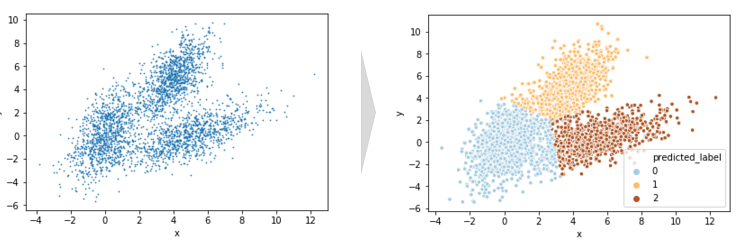

## Background

From the lecture, we know that the most common clustering algorithm people use is the K-means algorithm, but one of its shortcomings is that it is only feasible with numerical values. To handle and cluster categorical values, the K-modes algorithm was proposed to replace the Euclidean distance that is used as a distance measurement in the original K-means algorithm with the number of mismatched categorical features, or the so-called Hamming Distance. Then, the centroids are updated by calculating the mode of the categorical features belonging to the same cluster instead of the mean in the original K-means algorithm.

Unfortunately, real-world data often contain mixed data types, including both numerical and categorical features, so both K-means and K-modes cannot be used in these scenarios. But with the basic understanding that K-means and K-modes can handle numerical and categorical features respectively, we can immediately come up with an easy solution to **(1) adopt K-means procedures on the numerical feature columns of the mixed data**, and **(2) adopt K-modes procedures on the remaining categorical feature columns.** Finally, we can **sum** these two different distance measurements up to obtain the total distance that will be used to assign each point to the closest centroid. This is called the **K-prototype** algorithm, and you can consider it as **an ensemble of K-means and K-modes clustering algorithms**. All these three algorithms follow the same pipeline and, therefore, can switch between each other in a few lines of code.

The Hamming Distance: https://en.wikipedia.org/wiki/Hamming_distance<br />
K-modes and K-prototype clustering algorithm: https://link.springer.com/article/10.1023/A:1009769707641

Import libraries:

## Tasks Overview

To better understand K-means clustering and its variants, in this lab, you will implement the simplified K-prototype clustering from scratch with the help of NumPy. In the second part, we will look into how different parameters might alter the output of the algorithms. Please carefully read through the lab 4 review before attempting the lab 4 tasks. 

#### THIS CODE CELL IS FOR GRADING AND VISUALIZATION PURPOSES & PLEASE DO NOT ALTER IT

In [5]:
import numpy as np
from scipy import stats
from sklearn import cluster, datasets
from sklearn.preprocessing import KBinsDiscretizer

def isNotebook():
    # This function would return True if it's run inside a notebook or ipython environment.
    # False if it's in a normal Python interpreter. Otherwise, it'll raise an Error.
    # It is not necessary for you to understand this function.
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell' or shell == 'TerminalInteractiveShell' or shell == 'Shell':
            return True
        else:
            raise NotImplementedError
    except NameError:
        return False

if isNotebook():
    secret_number = 20                                  # This will be the seed of the random number generator
else:
    import pickle
    with open('secret_number.pkl', 'rb') as f:
        secret_number = pickle.load(f)                  # Only matters during grading

if isNotebook():
    import matplotlib.pyplot as plt

def plot_diagram(X, y=None, k=None):
    if not isNotebook():
        return
    from itertools import cycle
    cycol = cycle('rgbcmk')                             # Create a color cycle iterable object
    if y is not None:                                   # y is the label of each individual points
        if k is None:                                   # k is number of cluster there is
            k = y.max() + 1                             # The total number of clusters is the max label + 1, assuming
                                                        # the class labels are consecutive and start from 0
        for i, c in zip(range(k), cycol):
            print('label %s: %s' % (str(i), c))
            plt.scatter(*X[y == i].T, c=c)              # Plot points of class with color c

def plot_points(points, marker='o'):
    if not isNotebook():
        return
    plt.scatter(*points, c='w', marker=marker)          # Plot points with color white and specified shape
    pass


## Data Generation and Illustration Section
#### PLEASE DO NOT ALTER IT

Remarks: you may unintentionally change the output of this section if you do not run the code cell of this section in order. So you'd better not run this part of the code manually. They are just demos and won't affect your experimental results.

These lines create a dataset with 4 blobs of the cluster, and you can call the defined `plot_diagram` to draw it. The print-outs show the corresponding color of each cluster label from 0 to 3. 

label 0: r
label 1: g
label 2: b
label 3: c


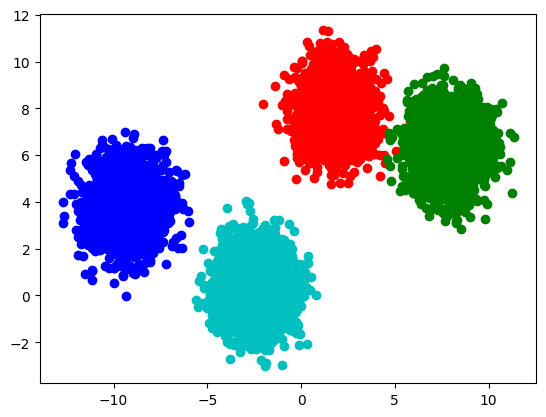

In [6]:
# Create a dataset with 4 blobs of cluster
X_ill, y_ill = datasets.make_blobs(10000, 2, centers=4, random_state=secret_number)
plot_diagram(X_ill, y_ill)

We have generated a toy dataset of shape (n_samples, n_features), in which **n_samples=10000** and **n_features=2**. The data points will be scattered around **4 clusters**.

In [7]:
print('X_ill.shape:', X_ill.shape)
print('y_ill.shape:', y_ill.shape)

X_ill.shape: (10000, 2)
y_ill.shape: (10000,)


What do they look like?

In [8]:
print('First 5 data instance of X_ill:\n', X_ill[0:5])
print('The labels of first 5 data instance of y_ill:\n', y_ill[0:5])

First 5 data instance of X_ill:
 [[ -2.74788293  -0.15905139]
 [ -1.82695673   0.6972823 ]
 [-10.81461608   2.34384601]
 [ -8.99656118   2.91953391]
 [ -9.66102009   4.71302798]]
The labels of first 5 data instance of y_ill:
 [3 3 2 2 2]


Currently, each of our data instances has two feature columns, and apparently, they are numerical (i.e., or in our task, we said **is_categ = np.array([False, False])**). Assuming we want to change the second feature column to categorical (i.e., **is_categ = np.array([False, True])**).<br />
Here is the preprocessing method in case you are interested: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html.<br />
See the difference in the second feature column. 

Bin edges: [array([-3.03518343, -1.23984714,  0.55548915,  2.35082543,  4.14616172,
         5.94149801,  7.73683429,  9.53217058, 11.32750687])            ]
First 5 data instance of X_categ_ill:
 [[ -2.74788293   1.        ]
 [ -1.82695673   2.        ]
 [-10.81461608   2.        ]
 [ -8.99656118   3.        ]
 [ -9.66102009   4.        ]]
The labels of first 5 data instance of X_ill:
 [3 3 2 2 2]
label 0: r
label 1: g
label 2: b
label 3: c
None


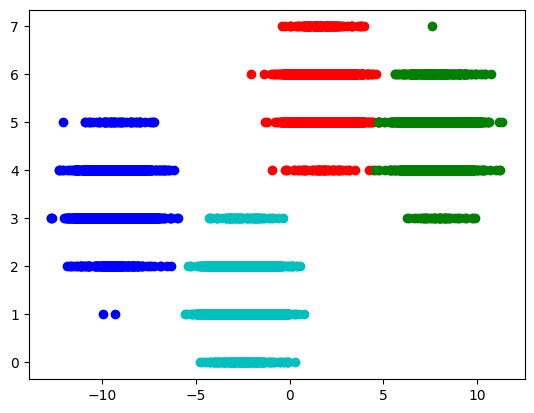

In [9]:
# Change the second feature columns from numerical to categorical
is_categ_ill = np.array([False, True])
X_categ_ill = X_ill.copy()
if np.count_nonzero(is_categ_ill) > 0:
    est_ill = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='uniform')
    est_ill.fit(X_ill[:, is_categ_ill])
    transformed_f_2 = est_ill.transform(X_ill[:, is_categ_ill])
    X_categ_ill[:, is_categ_ill] = transformed_f_2
    print('Bin edges:', est_ill.bin_edges_)
print('First 5 data instance of X_categ_ill:\n', X_categ_ill[0:5])
print('The labels of first 5 data instance of X_ill:\n', y_ill[0:5])
print(plot_diagram(X_categ_ill, y_ill))

Bin edges tell us that all numerical values between -3.03518343 and -1.23984714 are converted to 0, those between -1.23984714 and 0.55548915 are converted to 1, etc.

## Tasks

### Task 1: The K-prototype Clustering Algorithm

You need to fill in the blank space to implement the simplified K-prototype algorithm. In the `KPrototypes` class, there are four functions, `__init__,` `euclidean_distance,` `hamming_distanceand,` and `fit_predict.`

`__init__` is to init the variables of the algorithm. I.e., the prototypes (same as centroids). `euclidean_distance` and `hamming_distanceand` calculate the distance between each data point and prototypes using two different distance measurements. `fit_predict` would run the actual algorithm (called once for each run). 

The main algorithm (function `fit_predict`) of the K-prototype is as such (almost the same as the K-means in the review section):
   1. Choose K random data points as the initial "prototypes" (the mean of a cluster) of the dataset. 
   2. Compute the distance between each data point to the centroids in the current iteration.
   3. Assign each point to the closest centroid.
   4. With the current cluster assignments, find the centers of all the clusters and update the stored prototypes by these centers. 
   5. Repeat 2 to 4 until the criterion to leave the loop is met. 

Remarks: There are mainly two differences compared to the vanilla K-means algorithm: 
   1. In step 2.1, you first need to **extract the numerical feature columns** of data in **X** and that of the **stored prototypes**. Then, you only calculate the **Euclidean Distance** between these two **extracted feature columns**. This is the K-means part. The result is a distance matrix.
   2. In step 2.2, you need to **extract the categorical feature columns** of data in **X** and that of the **stored prototypes**. Then, you only calculate the **Hamming Distance** between these two **extracted feature columns**. This is the K-mode part. The result is a distance matrix.
   3. In step 2.3, finally, you will need to **element-wise sum** the two distance matrices computed from steps 2.1 and 2.2 together to obtain the total distance matrix. 
   4. In step 4.1, you first calculate the new centers of each cluster by computing the **mean values** using **only the numerical feature columns**.
   5. In step 4.2, you first calculate the new centers of each cluster by computing the **mode value** using **only the categorical feature columns**.
   6. In step 4.3, you first use the **mean-valued centers** from step 4.1 to update the **numerical feature columns of prototypes**. Then, you use the **mode-valued centers** from step 4.2 to update the **categorical feature columns of prototypes**.

If you get confused, please first read through the lab 4 review, all the comments in the class object, and the data illustration section.

In [123]:
class KPrototypes:
    def __init__(self, k, X, n_features, max_iter=100):
        """
        Initialization function for KPrototypes class. It is called every time an object is created from this class.
        :param k: int, required
        The number of clusters to form as well as the number of prototypes to generate.
        :param X: ndarray of shape (n_samples, n_features), required
        Training instances to cluster.
        :param n_features: int, required
        The number of dimensions of each data instance as well as the number of features. Including both categorical and
        numerical features.
        :param max_iter: int, default=100
        The maximum number of iterations of the K-prototypes algorithm for a single run.
        """
        self.k = k
        self.n_features = n_features
        self.max_iter = max_iter

        # TODO: Randomly select k data points from X as the initial prototypes.
        # Hint: Do not hardcode the indices of selected data points.
        # You may use Numpy's 'random.randint' function to randomly choose the initial prototypes.
        selected_idx = np.array(np.random.randint(0, X.shape[0], size=k))                                                 # ndarray of shape (k, )
        self.prototypes = X[selected_idx]                                             # ndarray of shape (k, n_features)

    def euclidean_distance(self, X, is_categ, debug_prototypes=None):
        """
        Calculate the Euclidean distance between each data point and prototypes. Only consider the numerical feature
        columns of each data point and prototypes.
        :param X: ndarray of shape (n_samples, n_features), required
        Training instances to cluster.
        :param is_categ: ndarray of shape (n_features,), required
        Array of boolean values indicates whether each feature column is categorical or not.
        e.g., is_categ=[False, False, True, True] indicates that feature 2 and feature 3 of dataset X are categorical.
        Then, the remaining feature columns (i.e., feature 0 and feature 1) are numerical.
        :param debug_prototypes: ndarray of shape (k, n_features), optional
        If debug_prototypes is given, it will be used in the calculation rather than the stored prototypes in the Class
        Object. This argument is only used to help you test the function independently. Do not use this argument in the
        fit_predict function.
        
        :return: ndarray of shape (n_prototypes, n_samples)
        The Euclidean distance between each data point and prototypes.
        """
        prototypes = debug_prototypes if debug_prototypes is not None else self.prototypes
        # TODO: only use the numerical feature columns to calculate the Euclidean distance between each data point and
        #       prototypes.
        # Hints:
        #   - Notice that X and prototypes have mismatched shapes.
        #     X: (n_samples, n_features)                    prototypes: (n_prototypes, n_features)
        #   - Only the numerical feature columns are used to calculate the Euclidean distance.
        #     X: (n_samples, n_numerical_features)          prototypes: (n_prototypes, n_numerical_features)
        #   - You may use Numpy's 'count_nonzero', 'reshape', and 'linalg.norm' (or 'sqrt' & 'sum') functions.
        #   - Try broadcasting.
        # n_numer_features = np.sum(~is_categ(X),axis=1)[0]                                             # number of numerical features
        numerical_arrayX=X[:,is_categ==0]
        numerical_arrayP=prototypes[:,is_categ==0]
        dist = np.power(np.sum(np.power(numerical_arrayP[:,np.newaxis] - numerical_arrayX[np.newaxis,:], 2), axis=2), 1/2)
        return dist

    def hamming_distance(self, X, is_categ, debug_prototypes=None):
        """
        Calculate the Hamming distance between each data point and prototypes. Only consider the categorical feature
        columns of each data point and prototypes.
        :param X: ndarray of shape (n_samples, n_features), required
        Training instances to cluster.
        :param is_categ: ndarray of shape (n_features,), required
        Array of boolean values indicates whether each feature column is categorical or not.
        e.g., is_categ=[False, False, True, True] indicates that feature 2 and feature 3 of dataset X are categorical.
        Then, the remaining feature columns (i.e., feature 0 and feature 1) are numerical.
        :param debug_prototypes: ndarray of shape (k, n_features), optional
        If debug_prototypes is given, it will be used in the calculation rather than the stored prototypes in the Class
        Object. This argument is only used to help you test the function independently. Do not use this argument in the
        fit_predict function.
        
        :return: ndarray of shape (n_prototypes, n_samples)
        The Hamming distance between each data point and prototypes.
        """
        prototypes = debug_prototypes if debug_prototypes is not None else self.prototypes
        # TODO: only use the categorical feature columns to calculate the Hamming distance between each data point and
        #       prototypes.
        # Hints:
        #   - Notice that X and prototypes have mismatched shapes.
        #     X: (n_samples, n_features)                    prototypes: (n_prototypes, n_features)
        #   - Only the categorical feature columns are used to calculate the Hamming distance.
        #     X: (n_samples, n_categorical_features)        prototypes: (n_prototypes, n_categorical_features)
        #   - You may use Numpy's 'count_nonzero', 'reshape', 'sum', and 'not_equal' functions.
        #   - Try broadcasting.
        # n_categ_features = np.sum(is_categ(X),axis=1)[0]                                         # number of categorical features
        cat_arrayX=X[:,is_categ==1]
        cat_arrayP=prototypes[:,is_categ==1]
        dist = np.sum(np.not_equal(cat_arrayP[:,np.newaxis,:],cat_arrayX[np.newaxis,:,:]),axis=2)
        return dist

    def fit_predict(self, X, is_categ):
        '''
        Compute cluster centers and predict cluster index for each sample.
        :param X: ndarray of shape (n_samples, n_features), required
        Training instances to cluster.
        :param is_categ: ndarray of shape (n_features,), required
        Array of boolean values indicates whether each feature column is categorical or not.
        e.g., is_categ=[False, False, True, True] indicates that feature 2 and feature 3 of dataset X are categorical.
        Then, the remaining feature columns (i.e., feature 0 and feature 1) are numerical.
        
        :return: ndarray of shape (n_samples,)
        Index of the cluster (serve as the label) each sample belongs to.
        '''
        prev_prototypes = None
        iteration = 0

        # TODO: Set the criterion to leave the loop.
        # Hints:
        #   - The criterion to leave the loop is to satisfy either of the two conditions:
        #     1. Convergence criterion: the prototypes are the same as those in the last iteration.
        #     2. Max number of iterations: the algorithm runs to the max number of iterations, i.e., self.max_iter
        #   - You may use Numpy's 'not_equal' and 'any' function.
        while iteration < self.max_iter and np.any(self.prototypes != prev_prototypes):

            # TODO: Assign the index of the closest prototype to each data point.
            # Hints: You may use numpy.argmin function to find the index of the closest prototype for each data point.
            numer_dist = self.euclidean_distance(X, is_categ)
            categ_dist = self.hamming_distance(X, is_categ)
            dist = numer_dist + categ_dist
            prototype_idx = np.argmin(dist,axis=0)

            prev_prototypes = self.prototypes.copy()            # Push current prototypes to previous.

            # TODO: Reassign prototypes as the mean of the clusters.
            # Hints:
            #  - We mentioned a method to choose specific elements from an array.
            #  - We mentioned that there were lots of functions from NumPy or scipy.stats for statistics.
            #    mean, std, median, mode, etc. On what axis should we find the statistics?
            #  - 'np.mean' and 'stats.mode' has different return shape. See how 'np.squeeze' works.
            for i in range(self.k):
                # A boolean array of shape (n_samples,). e.g., [False, True] means the second data sample is assigned to
                # cluster i but the first data sample is not.
                assigned_idx = (prototype_idx == i)
                if np.count_nonzero(assigned_idx) == 0:
                    continue

                if np.count_nonzero(~is_categ) > 0:
                    # Update the prototypes
                    self.prototypes[i,is_categ==0] = np.mean(X[assigned_idx,:][:, is_categ==0], axis=0)
                    
                if np.count_nonzero(is_categ) > 0:
                    # The returned ndarray of stats.mode does not have the same shape as the 'np.mean' function
                    categ_mode, _ = stats.mode(X[assigned_idx,:][:,is_categ==1], axis=0, keepdims=False)

                    # Convert this returned ndarray to the same shape as the 'np.mean' function before updating the prototypes
                    self.prototypes[i,is_categ==1] = np.squeeze(categ_mode)

            iteration += 1
        return prototype_idx


### Playground

We provide this playground for you to test your two distance functions defined in the class object. You can create your own test case and calculate the correct Euclidean Distance and Hamming Distance using a calculator. 

In [116]:
# Two data samples that have 4 features
debug_X = np.array([
    [1., 1., 1., 1.],
    [2., 4., 2., 4.]
])
# Three prototypes that have 4 features
debug_prototypes = np.array([
    [1., 1., 1., 1.],
    [1., 1., 2., 2.],
    [1., 2., 3., 1.]
])
debug_is_categ = np.array([False, False, True, True])       # The first two features are numerical while the last two
                                                            # features are categorical.
debug_model = KPrototypes(3, debug_X, 4)
print('Expected output of euclidean_distance:\n', np.array([[0., 3.16227766], [0., 3.16227766], [1., 2.23606798]]))
print('Your output of euclidean_distance:\n', debug_model.euclidean_distance(debug_X, debug_is_categ, debug_prototypes))
print('Expected output of hamming_distance:\n', np.array([[0, 2], [2, 1], [1, 2]]))
print('Your output of hamming_distance:\n', debug_model.hamming_distance(debug_X, debug_is_categ, debug_prototypes))

Expected output of euclidean_distance:
 [[0.         3.16227766]
 [0.         3.16227766]
 [1.         2.23606798]]
Your output of euclidean_distance:
 [[0.         3.16227766]
 [0.         3.16227766]
 [1.         2.23606798]]
Expected output of hamming_distance:
 [[0 2]
 [2 1]
 [1 2]]
Your output of hamming_distance:
 [[0 2]
 [2 1]
 [1 2]]


Also, for you to simply test the whole algorithm. But don't fully rely on this simple test. 

In [124]:
# Five data samples that have 4 features
debug_X = np.array([
    [1., 1., 1., 1.],
    [2., 4., 2., 4.],
    [1., 5., 1., 1.],
    [1., 1., 2., 2.],
    [2., 2., 3., 1.]
])
debug_is_categ = np.array([False, False, True, True])       # The first two features are numerical while the last two
                                                            # features are categorical.
np.random.seed(secret_number)
debug_model_1 = KPrototypes(2, debug_X, 4)
debug_labels_1 = debug_model_1.fit_predict(debug_X, debug_is_categ)
print('Expected output of debug_labels_1:', np.array([0, 1, 1, 0, 0]))
print('Your output of debug_labels_1:', debug_labels_1)

debug_model_2 = KPrototypes(3, debug_X, 4)
debug_labels_2 = debug_model_2.fit_predict(debug_X, debug_is_categ)
print('Expected output of debug_labels_2:', np.array([0, 2, 1, 0, 0]))
print('Your output of debug_labels_2:', debug_labels_2)

debug_model_3 = KPrototypes(4, debug_X, 4)
debug_labels_3 = debug_model_3.fit_predict(debug_X, debug_is_categ)
print('Expected output of debug_labels_3:', np.array([3, 2, 2, 1, 0]))
print('Your output of debug_labels_3:', debug_labels_3)

Expected output of debug_labels_1: [0 1 1 0 0]
Your output of debug_labels_1: [0 1 1 0 0]
Expected output of debug_labels_2: [0 2 1 0 0]
Your output of debug_labels_2: [0 2 1 0 0]
Expected output of debug_labels_3: [3 2 2 1 0]
Your output of debug_labels_3: [3 2 2 1 0]


### Task 2: Evaluation Metrics, Sum of Squared Errors

One common way to evaluate the quality of the clustering is using the Sum of Squared Errors (SSE) as a metric. It basically means summing the L2 distance (error) between each data point and the corresponding centroids for each cluster.

The formal definition of SSE is,

$$
    SSE = \sum_{j}^{M}\sum_{i}^{N_j}(x_i - c_j)^2
$$

where $M$ and $N_j$ represent the total number of clusters and elements inside cluster $j$, respectively. $x_i$ is the i<sup>th</sup> element in cluster $j$ and $c_j$ is the centroid of cluster $j$.

Implement SSE by following the equation above.

Remarks: For simplicity, consider only the vanilla SSE and trade all the feature columns as numerical.

In [127]:
def SSE(X, y, k, centroids):
    sse = 0
    # TODO: For each cluster, calculate the distance (square of difference, i.e. Euclidean/L2-distance) of samples to
    #  the datapoints and accumulate the sum to `sse`. (Hints: use numpy.sum and for loop)
    # Hints:
    #   - X is a Numpy 2D array with shape (num_datapoints, ndim), representing the data points.
    #   - y is a Numpy 1D array with shape (num_datapoints, ), representing which cluster (or which centroid) each data
    #   point correspond to.
    #   - This is very similar to the last TODO of Task 1
    for i in range(k):
        dist = np.sum(np.power(X[y == i][:,np.newaxis] - centroids[np.newaxis,i], 2), axis=2)
        sse += np.sum(dist)
    return sse

### Playground

We provide this playground for you to test your SSE functions. But don't fully rely on this simple test. You can create your own test case and calculate the correct SSE using a calculator. 

In [128]:
# Five data samples that have 4 features
debug_X = np.array([
    [1., 1., 1., 1.],
    [2., 4., 2., 4.],
    [1., 5., 1., 1.],
    [1., 1., 2., 2.],
    [2., 2., 3., 1.]
])
debug_is_categ = np.array([False, False, False, False])

np.random.seed(secret_number)
debug_model_4 = KPrototypes(2, debug_X, 4)
debug_labels_4 = debug_model_4.fit_predict(debug_X, debug_is_categ)
sse = SSE(debug_X, debug_labels_4, 2, debug_model_4.prototypes)
print('Expected SSE:', 10.0)
print('Your output of SSE:', round(sse, 5))

Expected SSE: 10.0
Your output of SSE: 10.0


## Results

After you finish writing the functions, you should see 4 individual blobs of points.

In [129]:
n_centers = 4
n_dim = 2
X, y = datasets.make_blobs(10000, n_dim, centers=n_centers, random_state=secret_number) # Create a dataset with 4 blobs of cluster
X_original = X.copy()
is_categ = np.array([False, True])
if np.count_nonzero(is_categ) > 0:
    est = KBinsDiscretizer(n_bins=n_centers * 2, encode='ordinal', strategy='uniform')
    est.fit(X[:, is_categ])
    X_categ = est.transform(X[:, is_categ])
    X[:, is_categ] = X_categ

np.random.seed(secret_number)                                                           # Set seeds to expect the same result everytime
model = KPrototypes(n_centers, X, n_dim)
initial_points = model.prototypes.copy()
labels = model.fit_predict(X, is_categ)
print('Expected first 20 labels:\n', np.array([3, 3, 0, 0, 0, 2, 3, 0, 2, 3, 3, 2, 1, 3, 0, 3, 0, 0, 2, 0]))
print('Your first 20 labels:\n', labels[0:20])

print('Expected prototypes:\n', np.array([[-9.28564381, 3.], [7.85330628, 5.], [1.76048471, 6.], [-2.46560541, 1.]]))
print('Your prototypes:\n', model.prototypes)

sse = SSE(X, labels, 4, model.prototypes)
print('Expected SSE:', 16006.74398)
print('Your SSE:', round(sse, 5))                                                           # SSE:  16006.74398

Expected first 20 labels:
 [3 3 0 0 0 2 3 0 2 3 3 2 1 3 0 3 0 0 2 0]
Your first 20 labels:
 [3 3 0 0 0 2 3 0 2 3 3 2 1 3 0 3 0 0 2 0]
Expected prototypes:
 [[-9.28564381  3.        ]
 [ 7.85330628  5.        ]
 [ 1.76048471  6.        ]
 [-2.46560541  1.        ]]
Your prototypes:
 [[-9.28564381  3.        ]
 [ 7.85330628  5.        ]
 [ 1.76048471  6.        ]
 [-2.46560541  1.        ]]
Expected SSE: 16006.74398
Your SSE: 16006.74398


Plot the data points using their original values (all feature columns in numerical values) with predicted labels.

label 0: r
label 1: g
label 2: b
label 3: c


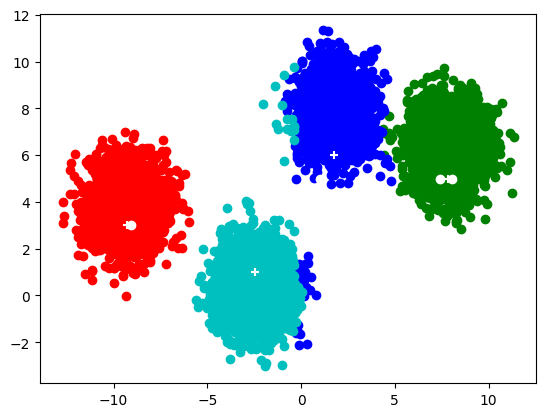

In [130]:
plot_diagram(X_original, labels, 4)
plot_points(model.prototypes.T, marker='+')
plot_points(initial_points.T, marker='o')

Plot the data points using their converted values (one feature column in categorical values).

label 0: r
label 1: g
label 2: b
label 3: c


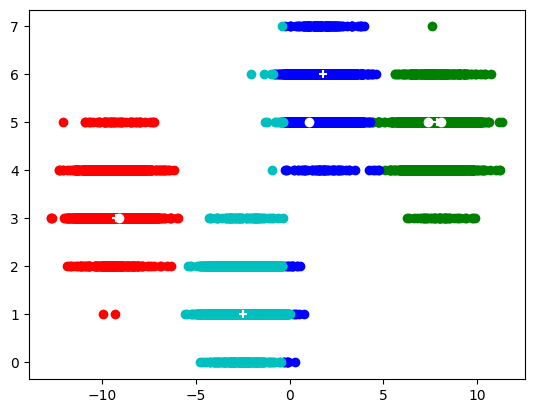

In [131]:
plot_diagram(X, labels, 4)
plot_points(model.prototypes.T, marker='+')
plot_points(initial_points.T, marker='o')

In the output above, the white circle dot represents the initial points, and the crosses represent the prototypes after the program is finished (after 100 iterations). As you can see, the program has successfully found the close-to-optimal points for this particular dataset. However, this leads to the discussion of the first limitation of K-means and its variants. The sensitivity of the choice of initial points.

In the next example, we will choose another set of random points (by altering the seeds). It turns out that by altering the initial points, we can purposefully make the algorithm settle on a suboptimal solution.

Expected SSE: 86994.40644
Your SSE: 86994.40644
label 0: r
label 1: g
label 2: b
label 3: c


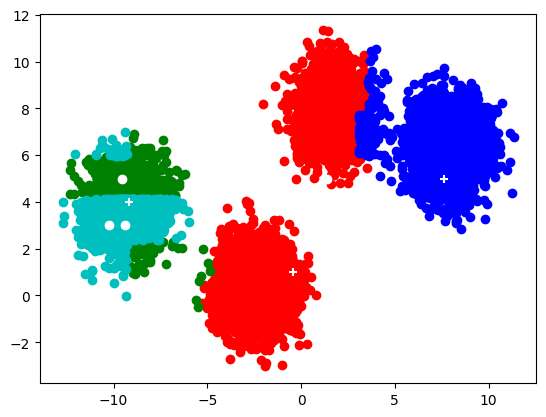

In [132]:
np.random.seed(11)                                                           # Set seeds to expect the same result everytime
model_11 = KPrototypes(n_centers, X, n_dim)
initial_points = model_11.prototypes.copy()
labels_11 = model_11.fit_predict(X, is_categ)

sse = SSE(X, labels_11, 4, model_11.prototypes)
print('Expected SSE:', 86994.40644)
print('Your SSE:', round(sse, 5))                                               # SSE:  86994.40644

plot_diagram(X_original, labels_11, 4)
plot_points(model_11.prototypes.T, marker='+')
plot_points(initial_points.T, marker='o')

label 0: r
label 1: g
label 2: b
label 3: c


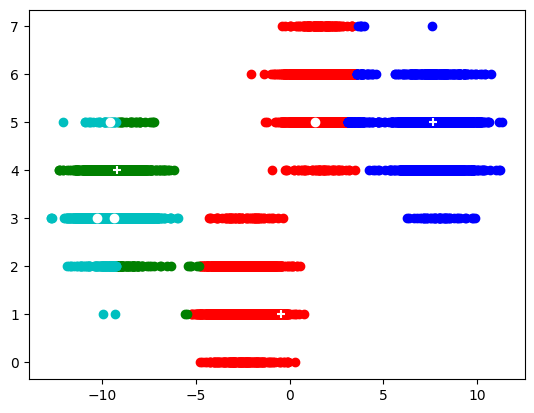

In [133]:
plot_diagram(X, labels_11, 4)
plot_points(model_11.prototypes.T, marker='+')
plot_points(initial_points.T, marker='o')

Remember that I once said that you could switch back and forth between the three algorithms with only a few lines of code? You have already done it! Let's try it.

Doing K-means:

Remarks: we only change is_categ = np.array([False, False])! This means all the feature columns are treated as numerical.

Expected SSE: 91995.10369
Your SSE: 91995.10369
label 0: r
label 1: g
label 2: b
label 3: c


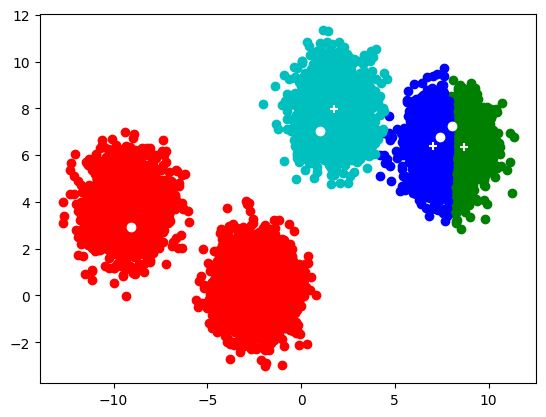

In [134]:
n_centers = 4
n_dim = 2
X_km, y_km = datasets.make_blobs(10000, n_dim, centers=n_centers, random_state=secret_number) # Create a dataset with 4 blobs of cluster
X_km_original = X_km.copy()
is_categ_km = np.array([False, False])
if np.count_nonzero(is_categ_km) > 0:
    est_km = KBinsDiscretizer(n_bins=n_centers * 2, encode='ordinal', strategy='uniform')
    est_km.fit(X_km[:, is_categ_km])
    X_categ_km = est_km.transform(X_km[:, is_categ_km])
    X_km[:, is_categ_km] = X_categ_km

np.random.seed(secret_number)                                                           # Set seeds to expect the same result everytime
model_km = KPrototypes(n_centers, X_km, n_dim)
initial_points_km = model_km.prototypes.copy()
labels_km = model_km.fit_predict(X_km, is_categ_km)

sse_km = SSE(X_km, labels_km, 4, model_km.prototypes)
print('Expected SSE:', 91995.10369)
print('Your SSE:', round(sse_km, 5))                                                           # SSE:  91995.10369
plot_diagram(X_km_original, labels_km, 4)
plot_points(model_km.prototypes.T, marker='+')
plot_points(initial_points_km.T, marker='o')

Don’t be scared! Remember the first limitation we covered in the lab 4 review? Let's try another seed. How about seed 42? The most popular one. 

Expected SSE: 20083.42822
Your SSE: 20083.42822
label 0: r
label 1: g
label 2: b
label 3: c


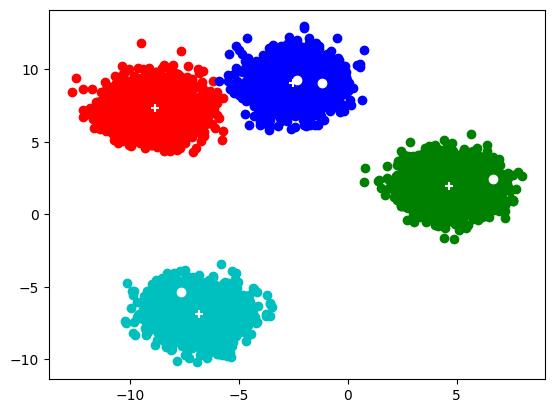

In [135]:
n_centers = 4
n_dim = 2
X_km, y_km = datasets.make_blobs(10000, n_dim, centers=n_centers, random_state=42) # Create a dataset with 4 blobs of cluster
X_km_original = X_km.copy()
is_categ_km = np.array([False, False])
if np.count_nonzero(is_categ_km) > 0:
    est_km = KBinsDiscretizer(n_bins=n_centers * 2, encode='ordinal', strategy='uniform')
    est_km.fit(X_km[:, is_categ_km])
    X_categ_km = est_km.transform(X_km[:, is_categ_km])
    X_km[:, is_categ_km] = X_categ_km

np.random.seed(secret_number)                                                           # Set seeds to expect the same result everytime
model_km = KPrototypes(n_centers, X_km, n_dim)
initial_points_km = model_km.prototypes.copy()
labels_km = model_km.fit_predict(X_km, is_categ_km)

sse_km = SSE(X_km, labels_km, 4, model_km.prototypes)
print('Expected SSE:', 20083.42822)
print('Your SSE:', round(sse_km, 5))                                               # SSE:  20083.42822
plot_diagram(X_km_original, labels_km, 4)
plot_points(model_km.prototypes.T, marker='+')
plot_points(initial_points_km.T, marker='o')

Looks good!

Let's also try on K-mode:

Remarks: we only change is_categ = np.array([True, True])! This means all the feature columns are treated as categorical.

Expected SSE: 13729.0
Your SSE: 13741.0
label 0: r
label 1: g
label 2: b
label 3: c


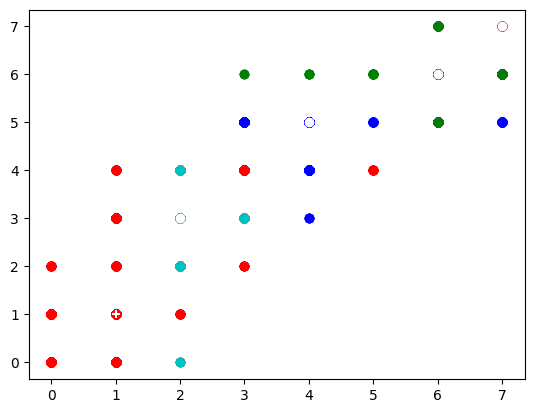

In [137]:
n_centers = 4
n_dim = 2
X_mo, y_mo = datasets.make_blobs(10000, n_dim, centers=n_centers, random_state=3) # Create a dataset with 4 blobs of cluster
X_mo_original = X_mo.copy()
is_categ_mo = np.array([True, True])
if np.count_nonzero(is_categ_mo) > 0:
    est_mo = KBinsDiscretizer(n_bins=n_centers * 2, encode='ordinal', strategy='uniform')
    est_mo.fit(X_mo[:, is_categ_mo])
    X_categ_mo = est_mo.transform(X_mo[:, is_categ_mo])
    X_mo[:, is_categ_mo] = X_categ_mo

np.random.seed(secret_number)                                                           # Set seeds to expect the same result everytime
model_mo = KPrototypes(n_centers, X_mo, n_dim)
initial_points_mo = model_mo.prototypes.copy()
labels_mo = model_mo.fit_predict(X_mo, is_categ_mo)

sse_mo = SSE(X_mo, labels_mo, 4, model_mo.prototypes)
print('Expected SSE:', 13729.0)          
print('Your SSE:', round(sse_mo, 5))                                                           # SSE:  13729.0
plot_diagram(X_mo, labels_mo, 4)
plot_points(model_mo.prototypes.T, marker='+')
plot_points(initial_points_mo.T, marker='o')

Looks messy? But it actually makes sense. Keep in mind for categorical features, the magnitude of their values is meaningless. We only care about if the two values we compared are the same or not. 


# Limitation of K-means and Its Variants

The sensitivity of the initial centroids is a very well-known problem of the K-means algorithm and its variants. In fact, there are more advanced algorithms for choosing better initial points (which we will not discuss here). Besides this, K-means and its variants still get a lot of other issues.

Although in our previous examples, the K-means algorithm had worked like a charm in clustering the dataset. However, in the real world, plain K-means clustering usually does not get us very far.

In our examples, we purposefully made our dataset blob-like instead of clusters with irregular shapes. That's because the blob-like structure is very apparent and obvious, so it's very easy to separate even in 2D (such as in our examples). However, in the following example, both K-means and K-prototypes clustering would fail miserably. That's mainly because this dataset isn't linearly separable (or at least not without some modifications to the input dimension, which is out of the scope of today's discussion). That is, K-means and K-prototypes clustering share some limitations.

label 0: r
label 1: g


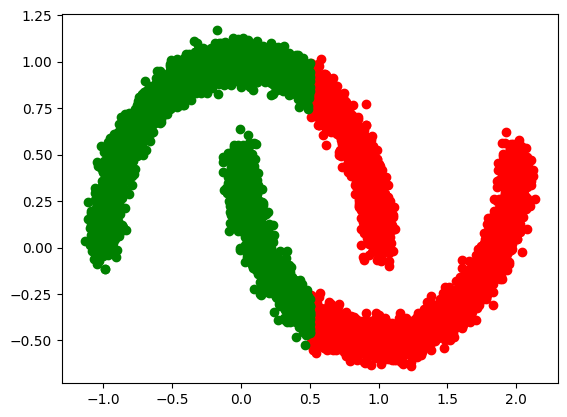

In [138]:
X_moons, y_moons = datasets.make_moons(10000, noise=0.05)
is_categ_moons = np.array([False, True])
model_moons = KPrototypes(2, X_moons, 2)
labels_moons = model_moons.fit_predict(X_moons, is_categ_moons)

# The two clusters are obviously not correctly separated.
plot_diagram(X_moons, labels_moons, 2)